In [1]:
from IPython import display
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import math
import time

In [2]:
def B_construct_1D(Na, ghosts_included = True):
    """
    Input: Na (int), number of grid points
           ghosts_included (bool), default is True (B is (Na-2) x (Na-2) and rho is Na-2)
                                           if False (B is (Na) x (Na) and rho is Na)
    Output: B (float array), 1D Poisson discretization matrix
    """
    # construct the tridiagonal Poisson discretization matrix B
    if (ghosts_included):
        
        offsets = [-1, 0, 1] 
        diags = []
        diags.append(-np.ones(Na-3)) 
        diags.append(2 * np.ones(Na-2))
        diags.append(-np.ones(Na-3))
        B = scipy.sparse.diags(diags, offsets, format='csr') # construct a CSR version of B
        B = B.toarray() # this function will only be called once so CSR not too important
        #print('The shape of B is', np.shape(B))
        #print('\nB is \n', B)        
    else:    
        offsets = [-1, 0, 1] 
        diags = []
        
        diags.append(-np.ones(Na-3)) 
        diags.append(2 * np.ones(Na-2))
        diags.append(-np.ones(Na-3))
        B = scipy.sparse.diags(diags, offsets, format='csr') # construct a CSR version of B
        B = B.toarray() # this function will only be called once so CSR not too important
        B = np.pad(B, [1, 1], mode='constant')
        B[0][0] = 1
        B[np.shape(B)[0]-1][np.shape(B)[0]-1] = 1
        #print('The shape of B is', np.shape(B))
        #print('\nB is \n', B)

    return B


def poisson_matrix_2D(Na, ghosts_included = True):
    
    B = B_construct_1D(Na, ghosts_included)
    
    if (ghosts_included):
        
        # construct the Poisson discretization matrix A
        A = np.kron(B, np.eye(np.shape(B)[0])) + np.kron(np.eye(np.shape(B)[0]), B)
        
    else:
        
        print('Error: Not Implemented yet :) OOPS')
    
    print('The shape of B is', np.shape(B))
    print('The shape of A is', np.shape(A))
    
    return A


def rho_update_2D(Na, n_alpha, q_alpha):
    
    rho = np.zeros(np.shape(n_alpha)[1:]) # set rho to Na x Na size, bypass the 1st array dimension
    
    # iterate over the alphas
    for i in range(np.shape(n_alpha)[0]):
        
        rho += n_alpha[i] * q_alpha[i]
        
    return rho # return 2D rho array
        

def phi_update_2D(Na, A_matrix, rho, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1): 
    
    a = 1.0/Na # calculate dx
    
    c_rho = a**2 * np.exp(1)**2 / (2.0 * epsilon_0 * epsilon_r) # IS THIS STILL THE SAME AS IT WAS IN 1D ?????
    
    if (ghosts_included):
        
        rho_vec = rho[1:-1,1:-1] # remove boundaries/ghosts
        rho_vec = rho_vec.flatten() # from 2D to 1D
        
        phi_soln = scipy.sparse.linalg.gmres(A_matrix, c_rho * rho_vec)[0]
        phi_soln = phi_soln.reshape((Na - 2, Na - 2))
        phi = np.pad(phi_soln,1)
    
    else:
        
        print('Error: Not Implemented yet :) OOPS')
        
    return phi # phi is returned as a 2D array here


def mu_and_v_alpha_update_2D(Na, mu_bar_alpha, q_alpha, phi, D_alpha):
    
    #Phi = phi.reshape((int(Na), int(Na))) # store Phi as a 2D Na x Na array
    
    a = 1.0/Na # dx
    
    # initialize mu_alpha
    mu_alpha = np.zeros(np.shape(mu_bar_alpha))

    # initialize v_alpha
    v_alpha = np.zeros(np.shape(mu_bar_alpha))
    
    for i in range(len(q_alpha)): # loop over 1st dimension (layer) of 3D mu_alpha & v_alpha tensors
        
        mu_alpha[i] = mu_bar_alpha[i] + q_alpha[i] * phi  

        v_alpha[i] = (1.0/a) * D_alpha[i]
          
    return mu_alpha, v_alpha # both returned as 3D alpha x Na x Na arrays
     

# Note : np.exp(mu - mu)'s should be calculated outside of the loops

In [3]:
def J_alpha_update_2D(Na, T, k_B, mu_alpha, v_alpha, n_alpha):
    """
    Input: Na (int), number of grid points
           T (float), temperature
           mu_alpha (float array), (Na) x (alpha) 
           v_alpha (float array), (Na) x (alpha) 
           n_alpha (float array), (Na) x (alpha) 
    Output: J_alpha (float array), (Na + 1) x (alpha) particle current array
    """
    
    # initialize J_alpha_UMat to have m x (Na) x (Na) dimensions
    J_alpha_UMat = np.zeros((np.shape(n_alpha)[0], np.shape(n_alpha)[1], np.shape(n_alpha)[2]))
    # Our update matrix which we will simply scale and then add on n_alpha_Current !!! Pretty COOL !
    
    # Our axes : +-----> (x-axis)
    #            |
    #            |
    #            v (y-axis)
    # each cell n_alpha has 4 possible neighbors, left, right, top, bottom
        # all of these neighbors exchange information to form dn/dt
        # NOTE: some cells have 2 (corner) or 3 (edge) neighbors which needs to be accounted for
    
    # now iterate over each grid index, update J_alpha_UMat values for all alphas each iteration
    
    c = 2 * k_B * T # just store as one value
    
    # 1st : Deal with the Interior (Na - 2) x (Na - 2) domain
    for i in range(1, np.shape(n_alpha)[1] - 1):
        for j in range(1, np.shape(n_alpha)[2] - 1):
            
            # signs given to be positive if flow into cell i,j
            J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c))
            J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c))
            J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c))
            J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c))
            
            J_alpha_UMat[:,i,j] = J_left + J_right + J_top + J_bottom
            
    
    # 2nd : Deal with the Edges
    for j in range(1, np.shape(n_alpha)[2] - 1):
        
        # left column
        i = 0
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c))
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c))
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c))
        J_alpha_UMat[:,i,j] = J_top + J_bottom + J_right # left column 
    
        # right column
        i = np.shape(n_alpha)[1] - 1
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c))
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c))
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c))
        J_alpha_UMat[:,i,j] = J_top + J_bottom + J_left # right column 
    
    for i in range(1, np.shape(n_alpha)[1] - 1):
    
        # top row
        j = 0
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c))
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c))
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c)) 
        J_alpha_UMat[:,i,j] = J_left + J_right + J_bottom
       
        # bottom row
        j = np.shape(n_alpha)[2] - 1
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c))
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c))
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c))
        J_alpha_UMat[:,i,j] = J_left + J_right + J_top   
    
    # 3rd : Deal with the Corners
    
    # top left corner
    i = 0
    j = 0
    J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c))
    J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c))
    J_alpha_UMat[:,i,j] = J_bottom + J_right 
    
    # top right corner
    i = np.shape(n_alpha)[1] - 1
    j = 0
    J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c))
    J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j+1])/(c))
    J_alpha_UMat[:,i,j] = J_bottom + J_left
    
    # bottom left corner
    i = 0
    j = np.shape(n_alpha)[2] - 1
    J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i+1,j])/(c))
    J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c))    
    J_alpha_UMat[:,i,j] = J_top + J_right
    
    # bottom right corner
    i = np.shape(n_alpha)[1] - 1
    j = np.shape(n_alpha)[2] - 1
    J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i-1,j])/(c))
    J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * np.exp(-(mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c)) - v_alpha[:,i,j] * n_alpha[:,i,j] * np.exp((mu_alpha[:,i,j] - mu_alpha[:,i,j-1])/(c))  
    J_alpha_UMat[:,i,j] = J_top + J_left
   
    return J_alpha_UMat




In [4]:
def n_alpha_update_Forward_2D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha_UMat):
    
    a = 1/Na # calculate dx
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # create B_x
    
    # initialize n_alpha_Update
    n_alpha_Update = np.zeros(np.shape(n_alpha_Past))

    # NOTE : The 1D J_Present method NOT implemented
                                    # needs to be dt * a
    n_alpha_Update = n_alpha_Current + (dt / a) * J_alpha_UMat
    
    # update the n_alpha's appropriately in preparation for the next iteration
    n_alpha_Past = n_alpha_Current
    n_alpha_Current = n_alpha_Update
    
    return n_alpha_Update, n_alpha_Current, n_alpha_Past

In [5]:
def iteration_Forward_2D(dt, i_glob, Na, T, k_B, A_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1):
    
    # update rho
    rho = rho_update_2D(Na, n_alpha_Current, q_alpha)
    
    # update phi
    phi = phi_update_2D(Na, A_matrix, rho, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
    
    # update mu_alpha & v_alpha, N O T E : combined mu_alpha_update_1D and v_alpha_update_1D into ONE function
    mu_alpha, v_alpha = mu_and_v_alpha_update_2D(Na, mu_bar_alpha, q_alpha, phi, D_alpha)
    
    # update J_alpha
    J_alpha_UMat = J_alpha_update_2D(Na, T, k_B, mu_alpha, v_alpha, n_alpha_Current)
    
    # update n_alpha
    n_alpha_Update, n_alpha_Current, n_alpha_Past = n_alpha_update_Forward_2D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha_UMat)
   
    return n_alpha_Update, n_alpha_Current, n_alpha_Past

In [6]:
def simulation_Forward_2D(dt, tmax, Na, T, k_B, n_alpha_Update, n_alpha_Current, n_alpha_Past, q_alpha, mu_bar_alpha, D_alpha, plotting = False): # dt, Na, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1
    
    i_glob = 0 # global iteration counter (specifically for 1st timestep's n'(x, t) calculation)
    t_cur = 0.0  # global time counter
    
    a = 1/Na # calculate dx
    
    A_x = np.arange(0, 1 + 1e-15, a)         # length of Na + 1
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na
    
    # initialize 
    n_alpha_Update = np.zeros((len(B_x), 1))
    n_plotting = np.array([])
    
    # construct the Poisson 1D discretization matrix B
    A_matrix = poisson_matrix_2D(Na, ghosts_included = True)
    
    # start plotting/animating
    fig = plt.figure() # initialize figure
    axis = plt.axes(xlim =(0, 1), ylim =(-2, 10)) # marking the x-axis and y-axis 
    line, = axis.plot([], [], lw = 3) # initializing a line variable 
    plt.close() # to not have a stray plot
    
    # data which the line will 
    # contain (x, y) 
    def init(): 
        line.set_data([], []) 
        return line, 
    
    def animate(i): 
        x = np.arange(a/2, 1 - a/2 + 1e-15, a) # set the x axis to B_x

        if (i < int(tmax/dt - 1e-15)):
            
            n_plot = n_plot_matrix[i,:] # extract the i^th row for plotting
        
            line.set_data(x, n_plot) 
            
        else:
            
            return line,
      
        return line,
    
    
    while (t_cur < tmax):
        
        n_alpha_Update, n_alpha_Current, n_alpha_Past = iteration_Forward_2D(dt, i_glob, Na, T, k_B, A_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
        
        if (plotting):
            
            n_plotting = np.append(n_plotting, n_alpha_Update)
                     
        i_glob += 1
        t_cur += dt
        
    if (plotting):
        
        n_plot_matrix = n_plotting.reshape((int(tmax/dt - 1e-15) + 1, len(B_x))) # every row corresponds to N_alpha 
                                                                 # at a different time-step  
        anim = FuncAnimation(fig, animate, init_func = init, frames = 500, interval = 20, blit = True)
        
        #return HTML(anim.to_jshtml())
        
        return anim
    
    else:
        
        print('\nSimulation completed at time', t_cur, '!!!')
        
        return n_alpha_Current, t_cur

In [7]:
Na = 51
T = 300
k_B = 1e6
a = 1.0/Na
dt = 0.5 * a**2
t_max = 200*dt
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([0])
mu_bar_alpha = np.zeros((1, Na, Na)) 
D_alpha = 1e-1 * np.ones((1, Na, Na))
                         
# Forward Euler temporal discretization
n_alpha_Update_FE = np.zeros((1, Na, Na))
n_alpha_Current_FE = np.zeros((1, Na, Na))
n_alpha_Past_FE = np.zeros((1, Na, Na))

n_CPFM_1D_forward = np.zeros((1, Na, Na))

N_mid = int((Na-1)/2)

n_alpha_Current_FE[:,N_mid, N_mid] = 10.0


start = time.time()    
# Store the 1D n_alpha array for plotting
n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
end = time.time()      
print('Time ellapsed w/ compiling =', end - start)


start = time.time()    
# Store the 1D n_alpha array for plotting
n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
end = time.time()      
print('Time ellapsed w/o compiling =', end - start)

The shape of B is (49, 49)
The shape of A is (2401, 2401)

Simulation completed at time 0.03844675124951942 !!!
Time ellapsed w/ compiling = 23.692017078399658
The shape of B is (49, 49)
The shape of A is (2401, 2401)

Simulation completed at time 0.03844675124951942 !!!
Time ellapsed w/o compiling = 23.53088116645813


In [8]:
def mu_and_v_alpha_update_2D(Na, mu_bar_alpha, q_alpha, phi, D_alpha):
    
    #Phi = phi.reshape((int(Na), int(Na))) # store Phi as a 2D Na x Na array
    
    a = 1.0/Na # dx
    
    # initialize mu_alpha
    mu_alpha = np.zeros(np.shape(mu_bar_alpha))

    # initialize v_alpha
    v_alpha = np.zeros(np.shape(mu_bar_alpha))
    
    for i in range(len(q_alpha)): # loop over 1st dimension (layer) of 3D mu_alpha & v_alpha tensors
        
        mu_alpha[i] = mu_bar_alpha[i] + q_alpha[i] * phi  

        v_alpha[i] = (1.0/a) * D_alpha[i]
        
    # now store mu_alpha as an exponential array 
    
    c = 2 * k_B * T # just store as one value
    
    mu_alpha = np.exp(mu_alpha/c)
    
    #print(phi)
    #print(mu_alpha)
          
    return mu_alpha, v_alpha # both returned as 3D alpha x Na x Na arrays
     

In [9]:
def J_alpha_update_2D(Na, T, k_B, mu_alpha, v_alpha, n_alpha):
    """
    Input: Na (int), number of grid points
           T (float), temperature
           mu_alpha (float array), (Na) x (alpha) 
           v_alpha (float array), (Na) x (alpha) 
           n_alpha (float array), (Na) x (alpha) 
    Output: J_alpha (float array), (Na + 1) x (alpha) particle current array
    """
    
    # initialize J_alpha_UMat to have m x (Na) x (Na) dimensions
    J_alpha_UMat = np.zeros((np.shape(n_alpha)[0], np.shape(n_alpha)[1], np.shape(n_alpha)[2]))
    # Our update matrix which we will simply scale and then add on n_alpha_Current !!! Pretty COOL !
    
    # Our axes : +-----> (x-axis)
    #            |
    #            |
    #            v (y-axis)
    # each cell n_alpha has 4 possible neighbors, left, right, top, bottom
        # all of these neighbors exchange information to form dn/dt
        # NOTE: some cells have 2 (corner) or 3 (edge) neighbors which needs to be accounted for
    
    # now iterate over each grid index, update J_alpha_UMat values for all alphas each iteration
    
    c = np.exp(-1) # just store as one value
    
    # 1st : Deal with the Interior (Na - 2) x (Na - 2) domain
    for i in range(1, np.shape(n_alpha)[1] - 1):
        for j in range(1, np.shape(n_alpha)[2] - 1):
            
            # signs given to be positive if flow into cell i,j
            J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
            J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
            J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
            J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
            
            J_alpha_UMat[:,i,j] = J_left + J_right + J_top + J_bottom
            
    
    # 2nd : Deal with the Edges
    for j in range(1, np.shape(n_alpha)[2] - 1):
        
        # left column
        i = 0
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_top + J_bottom + J_right # left column 
    
        # right column
        i = np.shape(n_alpha)[1] - 1
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_top + J_bottom + J_left # right column 
    
    for i in range(1, np.shape(n_alpha)[1] - 1):
    
        # top row
        j = 0
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_left + J_right + J_bottom
       
        # bottom row
        j = np.shape(n_alpha)[2] - 1
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_alpha_UMat[:,i,j] = J_left + J_right + J_top   
    
    # 3rd : Deal with the Corners
    
    # top left corner
    i = 0
    j = 0
    J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
    J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
    J_alpha_UMat[:,i,j] = J_bottom + J_right 
    
    # top right corner
    i = np.shape(n_alpha)[1] - 1
    j = 0
    J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
    J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
    J_alpha_UMat[:,i,j] = J_bottom + J_left
    
    # bottom left corner
    i = 0
    j = np.shape(n_alpha)[2] - 1
    J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
    J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1] 
    J_alpha_UMat[:,i,j] = J_top + J_right
    
    # bottom right corner
    i = np.shape(n_alpha)[1] - 1
    j = np.shape(n_alpha)[2] - 1
    J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
    J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
    J_alpha_UMat[:,i,j] = J_top + J_left
    
    return J_alpha_UMat



In [10]:
def n_alpha_update_Forward_2D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha_UMat):
    
    a = 1/Na # calculate dx
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # create B_x
    
    # initialize n_alpha_Update
    n_alpha_Update = np.zeros(np.shape(n_alpha_Past))

    # NOTE : The 1D J_Present method NOT implemented
                                    # needs to be dt * a
    n_alpha_Update = n_alpha_Current + (dt / a) * J_alpha_UMat
    
    # update the n_alpha's appropriately in preparation for the next iteration
    n_alpha_Past = n_alpha_Current
    n_alpha_Current = n_alpha_Update
    
    return n_alpha_Update, n_alpha_Current, n_alpha_Past

In [11]:
def iteration_Forward_2D(dt, i_glob, Na, T, k_B, A_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1):
    
    # update rho
    rho = rho_update_2D(Na, n_alpha_Current, q_alpha)
    
    # update phi
    phi = phi_update_2D(Na, A_matrix, rho, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
    
    # update mu_alpha & v_alpha, N O T E : combined mu_alpha_update_1D and v_alpha_update_1D into ONE function
    mu_alpha, v_alpha = mu_and_v_alpha_update_2D(Na, mu_bar_alpha, q_alpha, phi, D_alpha)
    
    # update J_alpha
    J_alpha_UMat = J_alpha_update_2D(Na, T, k_B, mu_alpha, v_alpha, n_alpha_Current)
    
    # update n_alpha
    n_alpha_Update, n_alpha_Current, n_alpha_Past = n_alpha_update_Forward_2D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha_UMat)
   
    return n_alpha_Update, n_alpha_Current, n_alpha_Past

In [12]:
def simulation_Forward_2D(dt, tmax, Na, T, k_B, n_alpha_Update, n_alpha_Current, n_alpha_Past, q_alpha, mu_bar_alpha, D_alpha, plotting = False): # dt, Na, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1
    
    i_glob = 0 # global iteration counter (specifically for 1st timestep's n'(x, t) calculation)
    t_cur = 0.0  # global time counter
    
    a = 1/Na # calculate dx
    
    A_x = np.arange(0, 1 + 1e-15, a)         # length of Na + 1
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na
    
    # initialize 
    n_alpha_Update = np.zeros((len(B_x), 1))
    n_plotting = np.array([])
    
    # construct the Poisson 1D discretization matrix B
    A_matrix = poisson_matrix_2D(Na, ghosts_included = True)
    
    # start plotting/animating
    fig = plt.figure() # initialize figure
    axis = plt.axes(xlim =(0, 1), ylim =(-2, 10)) # marking the x-axis and y-axis 
    line, = axis.plot([], [], lw = 3) # initializing a line variable 
    plt.close() # to not have a stray plot
    
    # data which the line will 
    # contain (x, y) 
    def init(): 
        line.set_data([], []) 
        return line, 
    
    def animate(i): 
        x = np.arange(a/2, 1 - a/2 + 1e-15, a) # set the x axis to B_x

        if (i < int(tmax/dt - 1e-15)):
            
            n_plot = n_plot_matrix[i,:] # extract the i^th row for plotting
        
            line.set_data(x, n_plot) 
            
        else:
            
            return line,
      
        return line,
    
    
    while (t_cur < tmax):
        
        n_alpha_Update, n_alpha_Current, n_alpha_Past = iteration_Forward_2D(dt, i_glob, Na, T, k_B, A_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
        
        if (plotting):
            
            n_plotting = np.append(n_plotting, n_alpha_Update)
                     
        i_glob += 1
        t_cur += dt
        
    if (plotting):
        
        n_plot_matrix = n_plotting.reshape((int(tmax/dt - 1e-15) + 1, len(B_x))) # every row corresponds to N_alpha 
                                                                 # at a different time-step  
        anim = FuncAnimation(fig, animate, init_func = init, frames = 500, interval = 20, blit = True)
        
        #return HTML(anim.to_jshtml())
        
        return anim
    
    else:
        
        print('\nSimulation completed at time', t_cur, '!!!')
        
        return n_alpha_Current, t_cur

new parameter $phase$ ==> each alpha can have its own phase (0 or 1) and the phase value would be a weighted average of the n_alpha particles and their respective phase values.   

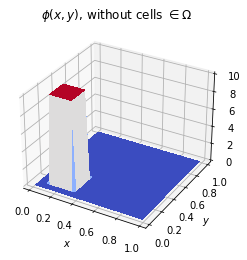

The shape of B is (29, 29)
The shape of A is (841, 841)

Simulation completed at time 1.3007284079084518 !!!
Time ellapsed w/o compiling = 151.47790098190308


In [64]:
Na = 31
T = 300
k_B = 1e2
a = 1.0/Na
dt = 0.5 * a**2
t_max = 2500*dt
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([500, 500]) #np.array([0,0]) #np.array([500, -500])
mu_bar_alpha = np.zeros((2, Na, Na))  # different mu_bar values for the alphas
D_alpha = 1e-1 * np.ones((2, Na, Na))
                         
# Forward Euler temporal discretization
n_alpha_Update_FE = np.zeros((2, Na, Na))
n_alpha_Current_FE = np.zeros((2, Na, Na))
n_alpha_Past_FE = np.zeros((2, Na, Na))

n_CPFM_1D_forward = np.zeros((2, Na, Na))

N_mid = int((Na-1)/2)

n_alpha_Current_FE[0,3:10, 3:10] = 10.0
#n_alpha_Current_FE[0,20:27, 20:27] = 10.0
#n_alpha_Current_FE[0] += 10
n_alpha_Current_FE[1,20:27, 20:27] = 10.0
#n_alpha_Current_FE[1,N_mid-1, N_mid-1] = 0.01



X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_alpha_Current_FE[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


#start = time.time()    
# Store the 1D n_alpha array for plotting
#n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
#end = time.time()      
#print('Time ellapsed w/ compiling =', end - start)


start = time.time()    
# Store the 1D n_alpha array for plotting
n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
end = time.time()      
print('Time ellapsed w/o compiling =', end - start)

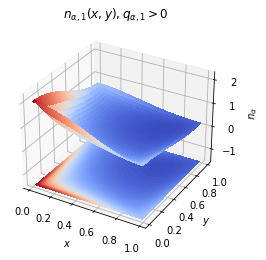

In [65]:
# 500, -500
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.contourf(xx, yy, n_CPFM_1D_forward[0],100, zdir='z', offset=-1.5,cmap=cm.coolwarm)
ax.set_title(r'$n_{\alpha,1}(x,y), q_{\alpha,1} > 0$')
ax.set_zlim([-1.5, 1.1 * np.max(n_CPFM_1D_forward[0])])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$n_\alpha$')
plt.show()

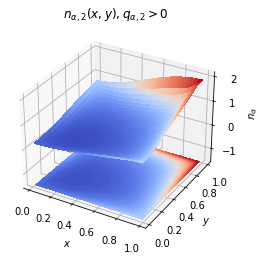

In [66]:
# 500, -500
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.contourf(xx, yy, n_CPFM_1D_forward[1],100, zdir='z', offset=-1.5,cmap=cm.coolwarm)
ax.set_title(r'$n_{\alpha,2}(x,y), q_{\alpha,2} > 0$')
ax.set_zlim([-1.5, 1.1 * np.max(n_CPFM_1D_forward[1])])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$n_\alpha$')
plt.show()

In [ ]:
fig= plt.figure()
ax= fig.add_subplot(111, projection= '3d')
surf=ax.plot_surface(xx,yy,Z,cmap='afmhot',linewidth=0,antialiased='True',rstride=3,cstride=3)
ax.contourf(X, Y, Z,100, zdir='z', offset=-1.5,cmap='afmhot')
fig.colorbar(surf)
plt.show()

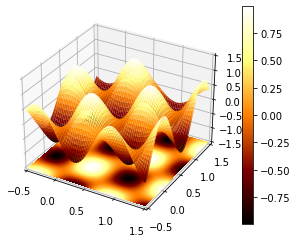

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
 
x= np.arange(-0.5,1.5,0.01)
y= np.arange(-0.5,1.5,0.01)
z= np.sin(10*x*y)
X,Y = np.meshgrid(x,y)
Z = np.sin(X*5)*np.cos(Y*5)
fig= plt.figure()
ax= fig.add_subplot(111, projection= '3d')
surf=ax.plot_surface(X,Y,Z,cmap='afmhot',linewidth=0,antialiased='True',rstride=3,cstride=3)
ax.contourf(X, Y, Z,100, zdir='z', offset=-1.5,cmap='afmhot')
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([-0.5, 1.5])
ax.set_zlim([-1.5, 1.5])
fig.colorbar(surf)
plt.show()

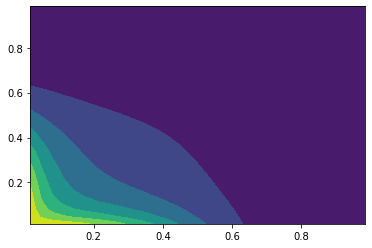

In [15]:
X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[0])

plt.show()

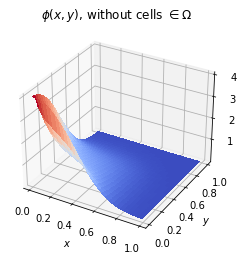

In [16]:
# 500, 500
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

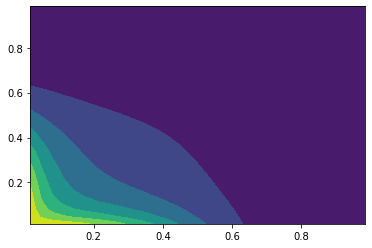

In [17]:
X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[0])

plt.show()

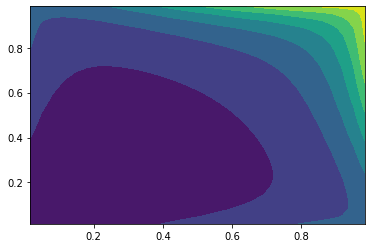

In [810]:
X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[1])

plt.show()

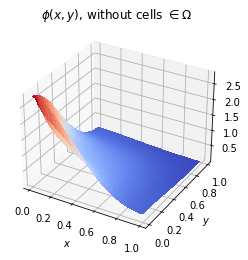

In [793]:
# 500, -500
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

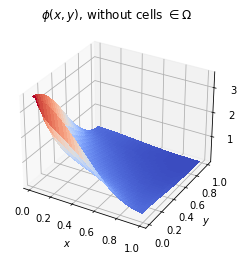

In [798]:
# 500, 500

X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

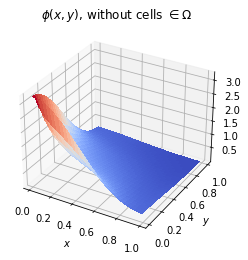

In [803]:
# 500, 0

X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

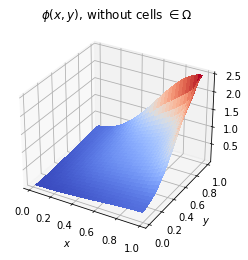

In [794]:
# 500, -500

X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

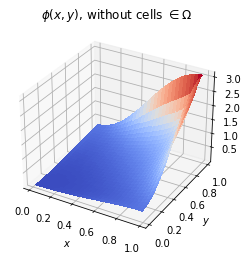

In [799]:
# 500, 500

X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

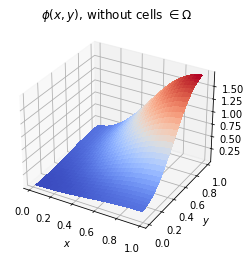

In [804]:
# 500, 0

X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

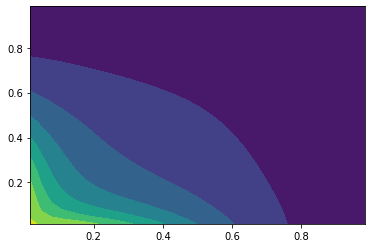

In [795]:
# 500, -500

X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[0])

plt.show()

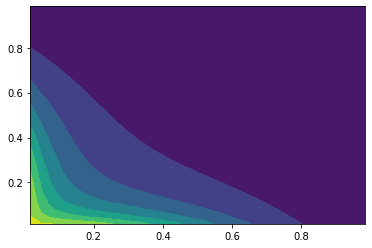

In [800]:
# 500, 500

X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[0])

plt.show()

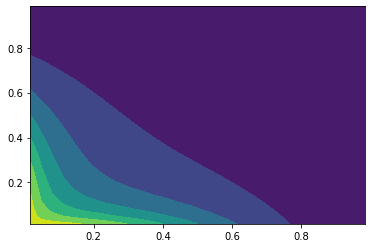

In [805]:
# 500, 0

X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[0])

plt.show()

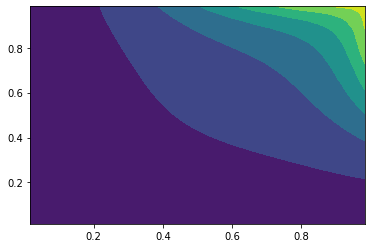

In [796]:
# 500, -500

X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[1])

plt.show()

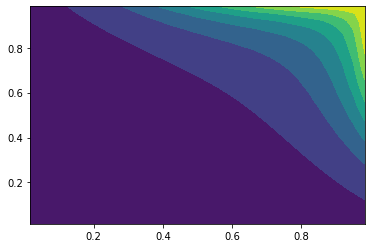

In [801]:
# 500, 500

X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[1])

plt.show()

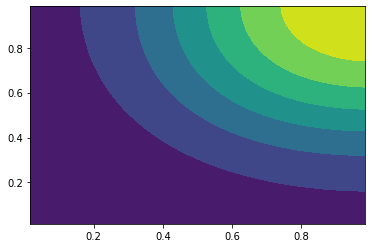

In [806]:
# 500, 0

X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[1])

plt.show()

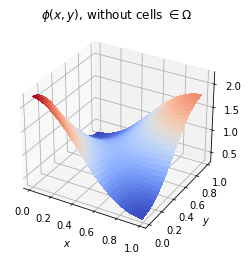

In [789]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

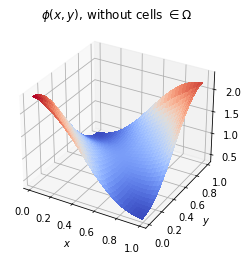

In [786]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

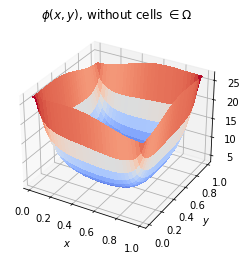

In [783]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

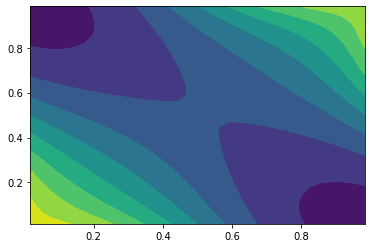

In [787]:
X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[0])

plt.show()

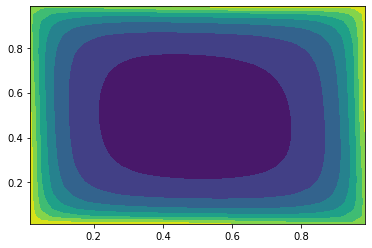

In [781]:
X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[0])

plt.show()

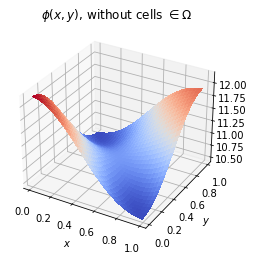

In [773]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [774]:
np.sum(n_CPFM_1D_forward[0])

10590.0

In [775]:
np.sum(n_CPFM_1D_forward[1])

490.00000000000006

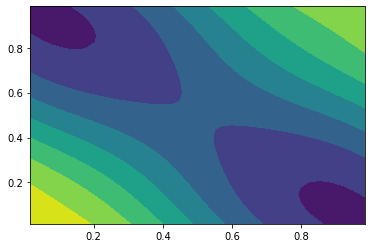

In [776]:
X = x_ax
Y = x_ax

xx, yy = X, Y

plt.contourf(xx, yy, n_CPFM_1D_forward[0])

plt.show()

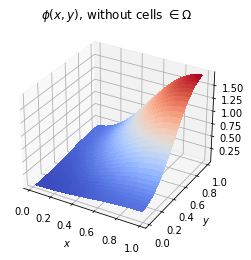

In [777]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

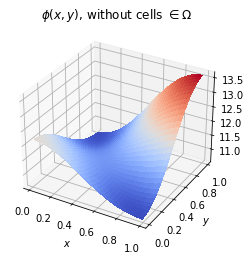

In [778]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0] + n_CPFM_1D_forward[1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

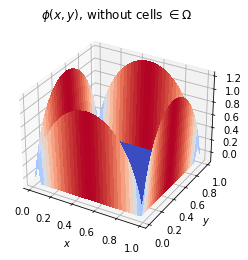

In [566]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

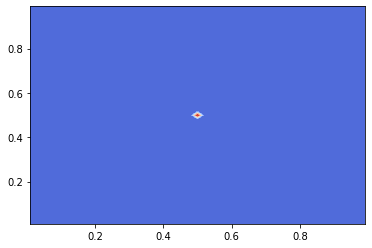

In [27]:
plt.contourf(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm, antialiased=False)

plt.show()


In [10]:
Na = 31
T = 300
k_B = 1e6
a = 1.0/Na
dt = 0.5 * a**2
t_max = 4000*dt
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([0])
mu_bar_alpha = np.zeros((1, Na, Na)) 
D_alpha = 1e-1 * np.ones((1, Na, Na))
                         
# Forward Euler temporal discretization
n_alpha_Update_FE = np.zeros((1, Na, Na))
n_alpha_Current_FE = np.zeros((1, Na, Na))
n_alpha_Past_FE = np.zeros((1, Na, Na))

n_CPFM_1D_forward = np.zeros((1, Na, Na))

N_mid = int((Na-1)/2)

n_alpha_Current_FE[:,N_mid, N_mid] = 10.0



    
# Store the 1D n_alpha array for plotting
n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
                                                      

The shape of B is (29, 29)
The shape of A is (841, 841)

Simulation completed at time 2.081165452653592 !!!


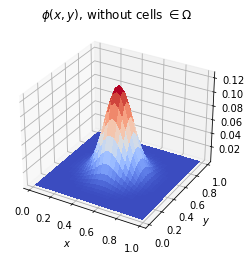

In [11]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

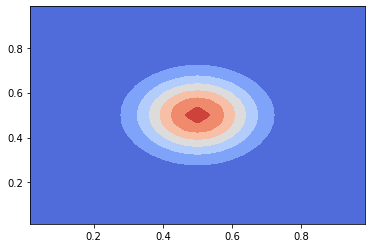

In [12]:
plt.contourf(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm, antialiased=False)

plt.show()


In [13]:
Na = 31
T = 300
k_B = 1e6
a = 1.0/Na
dt = 0.5 * a**2
t_max = 8000*dt
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([0])
mu_bar_alpha = np.zeros((1, Na, Na)) 
D_alpha = 1e-1 * np.ones((1, Na, Na))
                         
# Forward Euler temporal discretization
n_alpha_Update_FE = np.zeros((1, Na, Na))
n_alpha_Current_FE = np.zeros((1, Na, Na))
n_alpha_Past_FE = np.zeros((1, Na, Na))

n_CPFM_1D_forward = np.zeros((1, Na, Na))

N_mid = int((Na-1)/2)

n_alpha_Current_FE[:,N_mid, N_mid] = 10.0



    
# Store the 1D n_alpha array for plotting
n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
                                                      

The shape of B is (29, 29)
The shape of A is (841, 841)

Simulation completed at time 4.162851196669805 !!!


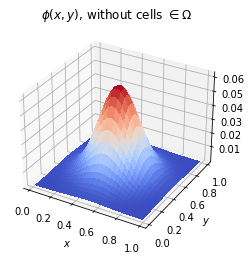

In [14]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

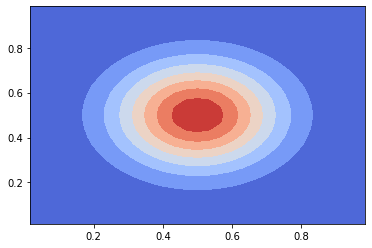

In [15]:
plt.contourf(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm, antialiased=False)

plt.show()

In [16]:
Na = 31
T = 300
k_B = 1e6
a = 1.0/Na
dt = 0.5 * a**2
t_max = 16000*dt
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([0])
mu_bar_alpha = np.zeros((1, Na, Na)) 
D_alpha = 1e-1 * np.ones((1, Na, Na))
                         
# Forward Euler temporal discretization
n_alpha_Update_FE = np.zeros((1, Na, Na))
n_alpha_Current_FE = np.zeros((1, Na, Na))
n_alpha_Past_FE = np.zeros((1, Na, Na))

n_CPFM_1D_forward = np.zeros((1, Na, Na))

N_mid = int((Na-1)/2)

n_alpha_Current_FE[:,N_mid, N_mid] = 10.0



    
# Store the 1D n_alpha array for plotting
n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
                                                      

The shape of B is (29, 29)
The shape of A is (841, 841)

Simulation completed at time 8.324661810615462 !!!


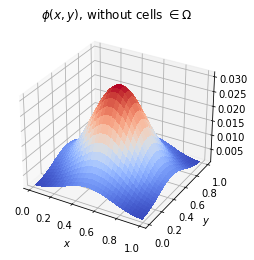

In [17]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


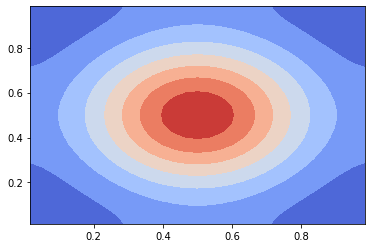

In [18]:
plt.contourf(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm, antialiased=False)

plt.show()


In [19]:
Na = 31
T = 300
k_B = 1e6
a = 1.0/Na
dt = 0.5 * a**2
t_max = 32000*dt
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([0])
mu_bar_alpha = np.zeros((1, Na, Na)) 
D_alpha = 1e-1 * np.ones((1, Na, Na))
                         
# Forward Euler temporal discretization
n_alpha_Update_FE = np.zeros((1, Na, Na))
n_alpha_Current_FE = np.zeros((1, Na, Na))
n_alpha_Past_FE = np.zeros((1, Na, Na))

n_CPFM_1D_forward = np.zeros((1, Na, Na))

N_mid = int((Na-1)/2)

n_alpha_Current_FE[:,N_mid, N_mid] = 10.0



    
# Store the 1D n_alpha array for plotting
n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
                                             

The shape of B is (29, 29)
The shape of A is (841, 841)

Simulation completed at time 16.649843912583165 !!!


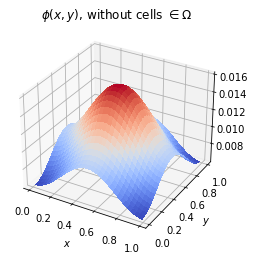

In [20]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


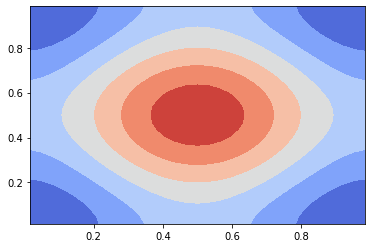

In [21]:
plt.contourf(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm, antialiased=False)

plt.show()


In [22]:
# Initial condition is a Steady-State

Na = 31
T = 300
k_B = 1e6
a = 1.0/Na
dt = 0.5 * a**2
t_max = 8000*dt
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([0])
mu_bar_alpha = np.zeros((1, Na, Na)) 
D_alpha = 1e-1 * np.ones((1, Na, Na))
                         
# Forward Euler temporal discretization
n_alpha_Update_FE = np.zeros((1, Na, Na))
n_alpha_Current_FE = np.ones((1, Na, Na))
n_alpha_Past_FE = np.zeros((1, Na, Na))

n_CPFM_1D_forward = np.zeros((1, Na, Na))

    
# Store the 1D n_alpha array for plotting
n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
                                             

The shape of B is (29, 29)
The shape of A is (841, 841)

Simulation completed at time 4.162851196669805 !!!


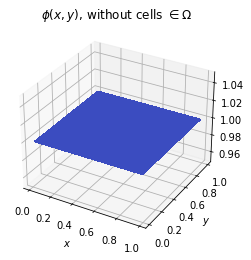

In [23]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()



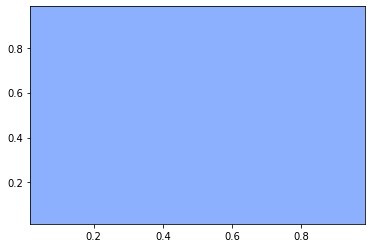

In [24]:
plt.contourf(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm, antialiased=False)

plt.show()


# Error Convergence Analysis

<br>

The analytical solution for polar coordinates is given by

$$ n_\alpha(r, t) = \frac{\bar{n_\alpha}}{4 \pi  D  t} exp \left( - \frac{r^2}{4 D t} \right) $$

(http://rpdata.caltech.edu/courses/aph162/2006/Protocols/diffusion.pdf)

<br>

So in Cartesian coordinates :

$$ n_\alpha(x, y, t) = \frac{\bar{n_\alpha}}{4 \pi  D  t} exp \left( - \frac{x^2 + y^2}{4 D t} \right) $$

Since we are starting with one initially populated cell located at the middle, we can simply replace the coordinates $x$ and $y$ by $x-x_0$ and $y-y_0$ to obtain

$$ n_\alpha(x, y, t) = \frac{\bar{n_\alpha}}{4 \pi  D  t} exp \left( - \frac{(x-x_0)^2 + (y-y_0)^2}{4 D t} \right) $$


**Note :** $ \bar{n_\alpha} \equiv$ `n_alpha_Current_FE[:,N_mid, N_mid] / Na**2`


In [66]:
def diffusion_analytical_2D(Na, t, n_0 = 10.0, D = 0.1, x_0 = 0.5, y_0 = 0.5):
    
    a = 1.0/Na # dx
    
    x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na
    y_ax = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na
    
    n_analytical = np.zeros((np.shape(x_ax)[0], np.shape(y_ax)[0]))
    
    for i in range(np.shape(x_ax)[0]):
        for j in range(np.shape(y_ax)[0]):
            
            n_analytical[i][j] = (n_0 / (4 * np.pi * D * t * Na**2)) * np.exp(-((x_ax[i] - x_0)**2 + (y_ax[j] - y_0)**2)/(4 * D * t))
    
    return n_analytical


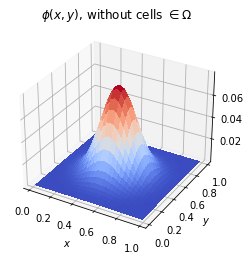

In [98]:
t = 0.10457856399583736

n_Analytical = diffusion_analytical_2D(Na, t, n_0 = 10.0, D = 0.1, x_0 = 0.5, y_0 = 0.5)


X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_Analytical, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

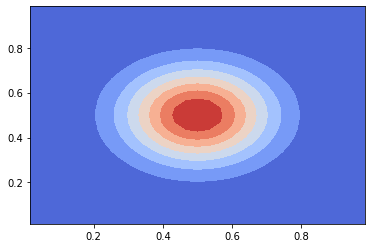

In [99]:
plt.contourf(xx, yy, n_Analytical, cmap=cm.coolwarm, antialiased=False)

plt.show()



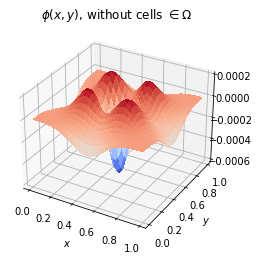

In [100]:
xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_Analytical - n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

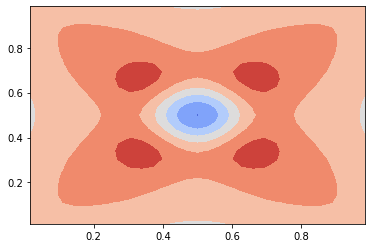

In [101]:
plt.contourf(xx, yy, n_Analytical - n_CPFM_1D_forward[0], cmap=cm.coolwarm, antialiased=False)

plt.show()



In [26]:
np.shape(np.arange(a/2, 1 - a/2 + 1e-15, a))

(31,)

# NumBa


In [53]:
from numba import jit, njit, vectorize, prange

In [97]:
@njit
def B_construct_1D(Na, ghosts_included = True):
    """
    Input: Na (int), number of grid points
           ghosts_included (bool), default is True (B is (Na-2) x (Na-2) and rho is Na-2)
                                           if False (B is (Na) x (Na) and rho is Na)
    Output: B (float array), 1D Poisson discretization matrix
    """
    # construct the tridiagonal Poisson discretization matrix B
    if (ghosts_included):
        
        B = np.diag(2*np.ones(Na-2), 0) - np.diag(np.ones(Na-3), -1) - np.diag(np.ones(Na-3), 1)
              
    else:    
        # NOT WORKING WITH Numba
        B = np.diag(2*np.ones(Na-2), 0) - np.diag(np.ones(Na-3), -1) - np.diag(np.ones(Na-3), 1)
        #B = np.pad(B, [1, 1], mode='constant')
        #B[0][0] = 1
        #B[np.shape(B)[0]-1][np.shape(B)[0]-1] = 1
        #print('The shape of B is', np.shape(B))
        #print('\nB is \n', B)

    return B

@njit
def poisson_matrix_2D(Na, B_matrix, ghosts_included = True):
    
    if (ghosts_included):
        
        # construct the Poisson discretization matrix A
        A = np.kron(B_matrix, np.eye(np.shape(B_matrix)[0])) + np.kron(np.eye(np.shape(B_matrix)[0]), B_matrix)
        
    else:
        
        print('Error: Not Implemented yet :) OOPS')
    
    print('The shape of B is', np.shape(B_matrix))
    print('The shape of A is', np.shape(A))
    
    return A

@njit
def rho_update_2D(Na, n_alpha, q_alpha):
    
    rho = np.zeros(np.shape(n_alpha)[1:]) # set rho to Na x Na size, bypass the 1st array dimension
    
    # iterate over the alphas
    for i in range(np.shape(n_alpha)[0]):
        
        rho += n_alpha[i] * q_alpha[i]
        
    return rho # return 2D rho array
        
@njit
def phi_update_2D(Na, A_matrix, rho, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1): 
    
    a = 1.0/Na # calculate dx
    
    c_rho = a**2 * np.exp(1)**2 / (2.0 * epsilon_0 * epsilon_r) # IS THIS STILL THE SAME AS IT WAS IN 1D ?????
    
    if (ghosts_included):
        
        rho_vec = rho[1:-1,1:-1] # remove boundaries/ghosts
        rho_vec = rho_vec.flatten() # from 2D to 1D
        
        #phi_soln = scipy.sparse.linalg.cg(A_matrix, c_rho * rho_vec)[0]
        ####
        # Implement your own GMRES based on numpy
        ####
        phi_soln = np.linalg.solve(A_matrix, c_rho * rho_vec)
        phi_soln = phi_soln.reshape((Na - 2, Na - 2))
        #phi = np.pad(phi_soln,1)
        
        # my np.pad() implementation
        phi = np.zeros((Na, Na))
        for i in range(1, Na-1):
            for j in range(1, Na-1):
                phi[i,j] = phi_soln[i-1,j-1]
                
    
    else:
        
        print('Error: Not Implemented yet :) OOPS')
        
    return phi # phi is returned as a 2D array here

@njit
def mu_and_v_alpha_update_2D(Na, mu_bar_alpha, q_alpha, phi, D_alpha):
    
    #Phi = phi.reshape((int(Na), int(Na))) # store Phi as a 2D Na x Na array
    
    a = 1.0/Na # dx
    
    # initialize mu_alpha
    mu_alpha = np.zeros(np.shape(mu_bar_alpha))

    # initialize v_alpha
    v_alpha = np.zeros(np.shape(mu_bar_alpha))
    
    for i in range(len(q_alpha)): # loop over 1st dimension (layer) of 3D mu_alpha & v_alpha tensors
        
        mu_alpha[i] = mu_bar_alpha[i] + q_alpha[i] * phi  

        v_alpha[i] = (1.0/a) * D_alpha[i]
        
    # now store mu_alpha as an exponential array 
    
    c = 2 * k_B * T # just store as one value
    
    mu_alpha = np.exp(mu_alpha/c)
          
    return mu_alpha, v_alpha # both returned as 3D alpha x Na x Na arrays
     

In [98]:
@njit
def J_alpha_update_2D(Na, T, k_B, mu_alpha, v_alpha, n_alpha):
    """
    Input: Na (int), number of grid points
           T (float), temperature
           mu_alpha (float array), (Na) x (alpha) 
           v_alpha (float array), (Na) x (alpha) 
           n_alpha (float array), (Na) x (alpha) 
    Output: J_alpha (float array), (Na + 1) x (alpha) particle current array
    """
    
    # initialize J_alpha_UMat to have m x (Na) x (Na) dimensions
    J_alpha_UMat = np.zeros((np.shape(n_alpha)[0], np.shape(n_alpha)[1], np.shape(n_alpha)[2]))
    # Our update matrix which we will simply scale and then add on n_alpha_Current !!! Pretty COOL !
    
    # Our axes : +-----> (x-axis)
    #            |
    #            |
    #            v (y-axis)
    # each cell n_alpha has 4 possible neighbors, left, right, top, bottom
        # all of these neighbors exchange information to form dn/dt
        # NOTE: some cells have 2 (corner) or 3 (edge) neighbors which needs to be accounted for
    
    # now iterate over each grid index, update J_alpha_UMat values for all alphas each iteration
    
    c = np.exp(-1) # just store as one value
    
    # 1st : Deal with the Interior (Na - 2) x (Na - 2) domain
    for i in range(1, np.shape(n_alpha)[1] - 1):
        for j in range(1, np.shape(n_alpha)[2] - 1):
            
            # signs given to be positive if flow into cell i,j
            J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
            J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
            J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
            J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
            
            J_alpha_UMat[:,i,j] = J_left + J_right + J_top + J_bottom
            
    
    # 2nd : Deal with the Edges
    for j in range(1, np.shape(n_alpha)[2] - 1):
        
        # left column
        i = 0
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_top + J_bottom + J_right # left column 
    
        # right column
        i = np.shape(n_alpha)[1] - 1
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_top + J_bottom + J_left # right column 
    
    for i in range(1, np.shape(n_alpha)[1] - 1):
    
        # top row
        j = 0
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
        J_alpha_UMat[:,i,j] = J_left + J_right + J_bottom
       
        # bottom row
        j = np.shape(n_alpha)[2] - 1
        J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
        J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
        J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
        J_alpha_UMat[:,i,j] = J_left + J_right + J_top   
    
    # 3rd : Deal with the Corners
    
    # top left corner
    i = 0
    j = 0
    J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
    J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
    J_alpha_UMat[:,i,j] = J_bottom + J_right 
    
    # top right corner
    i = np.shape(n_alpha)[1] - 1
    j = 0
    J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
    J_bottom = v_alpha[:,i,j+1] * n_alpha[:,i,j+1] * mu_alpha[:,i,j+1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j+1]
    J_alpha_UMat[:,i,j] = J_bottom + J_left
    
    # bottom left corner
    i = 0
    j = np.shape(n_alpha)[2] - 1
    J_right = v_alpha[:,i+1,j] * n_alpha[:,i+1,j] * mu_alpha[:,i+1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i+1,j]
    J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1] 
    J_alpha_UMat[:,i,j] = J_top + J_right
    
    # bottom right corner
    i = np.shape(n_alpha)[1] - 1
    j = np.shape(n_alpha)[2] - 1
    J_left = v_alpha[:,i-1,j] * n_alpha[:,i-1,j] * mu_alpha[:,i-1,j] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i-1,j]
    J_top = v_alpha[:,i,j-1] * n_alpha[:,i,j-1] * mu_alpha[:,i,j-1] / mu_alpha[:,i,j] - v_alpha[:,i,j] * n_alpha[:,i,j] * mu_alpha[:,i,j] / mu_alpha[:,i,j-1]
   
    return J_alpha_UMat


In [99]:
@njit
def n_alpha_update_Forward_2D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha_UMat):
    
    a = 1/Na # calculate dx
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # create B_x
    
    # initialize n_alpha_Update
    n_alpha_Update = np.zeros(np.shape(n_alpha_Past))

    # NOTE : The 1D J_Present method NOT implemented
                                    # needs to be dt * a
    n_alpha_Update = n_alpha_Current + (dt / a) * J_alpha_UMat
    
    # update the n_alpha's appropriately in preparation for the next iteration
    n_alpha_Past = n_alpha_Current
    n_alpha_Current = n_alpha_Update
    
    return n_alpha_Update, n_alpha_Current, n_alpha_Past

In [100]:
@njit
def iteration_Forward_2D(dt, i_glob, Na, T, k_B, A_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1):
    
    # update rho
    rho = rho_update_2D(Na, n_alpha_Current, q_alpha)
    
    # update phi
    phi = phi_update_2D(Na, A_matrix, rho, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
    
    # update mu_alpha & v_alpha, N O T E : combined mu_alpha_update_1D and v_alpha_update_1D into ONE function
    mu_alpha, v_alpha = mu_and_v_alpha_update_2D(Na, mu_bar_alpha, q_alpha, phi, D_alpha)
    
    # update J_alpha
    J_alpha_UMat = J_alpha_update_2D(Na, T, k_B, mu_alpha, v_alpha, n_alpha_Current)
    
    # update n_alpha
    n_alpha_Update, n_alpha_Current, n_alpha_Past = n_alpha_update_Forward_2D(dt, Na, n_alpha_Update, n_alpha_Current, n_alpha_Past, J_alpha_UMat)
   
    return n_alpha_Update, n_alpha_Current, n_alpha_Past

In [101]:

def simulation_Forward_2D(dt, tmax, Na, T, k_B, n_alpha_Update, n_alpha_Current, n_alpha_Past, q_alpha, mu_bar_alpha, D_alpha, plotting = False): # dt, Na, B_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1
    
    i_glob = 0 # global iteration counter (specifically for 1st timestep's n'(x, t) calculation)
    t_cur = 0.0  # global time counter
    
    a = 1/Na # calculate dx
    
    A_x = np.arange(0, 1 + 1e-15, a)         # length of Na + 1
    B_x = np.arange(a/2, 1 - a/2 + 1e-15, a) # length of Na
    
    # initialize 
    #n_alpha_Update = np.zeros((len(B_x), 1))
    #n_plotting = np.array([])
    
    # construct the B matrix
    B_matrix = B_construct_1D(Na, ghosts_included = True)
    
    # construct the Poisson 1D discretization matrix B
    A_matrix = poisson_matrix_2D(Na, B_matrix, ghosts_included = True)
    
    # start plotting/animating
    #fig = plt.figure() # initialize figure
    #axis = plt.axes(xlim =(0, 1), ylim =(-2, 10)) # marking the x-axis and y-axis 
    #line, = axis.plot([], [], lw = 3) # initializing a line variable 
    #plt.close() # to not have a stray plot
    
    # data which the line will 
    # contain (x, y) 
    #def init(): 
    #    line.set_data([], []) 
    #    return line, 
    
    #def animate(i): 
    #    x = np.arange(a/2, 1 - a/2 + 1e-15, a) # set the x axis to B_x

    #    if (i < int(tmax/dt - 1e-15)):
            
    #        n_plot = n_plot_matrix[i,:] # extract the i^th row for plotting
        
    #        line.set_data(x, n_plot) 
            
    #    else:
            
    #        return line,
      
    #    return line,
    
    
    while (t_cur < tmax):
        
        n_alpha_Update, n_alpha_Current, n_alpha_Past = iteration_Forward_2D(dt, i_glob, Na, T, k_B, A_matrix, q_alpha, n_alpha_Update, n_alpha_Current, n_alpha_Past, mu_bar_alpha, D_alpha, ghosts_included = True, epsilon_0 = 1, epsilon_r = 1)
        
        #if (plotting):
            
            #n_plotting = np.append(n_plotting, n_alpha_Update)
                     
        i_glob += 1
        t_cur += dt
        
    #if (plotting):
        
        #n_plot_matrix = n_plotting.reshape((int(tmax/dt - 1e-15) + 1, len(B_x))) # every row corresponds to N_alpha 
                                                                 # at a different time-step  
        #anim = FuncAnimation(fig, animate, init_func = init, frames = 500, interval = 20, blit = True)
        
        #return HTML(anim.to_jshtml())
        
        #return anim
    
    #else:
        
    print('\nSimulation completed at time', t_cur, '!!!')
        
    return n_alpha_Current, t_cur

In [102]:
Na = 51
T = 300
k_B = 1e6
a = 1.0/Na
dt = 0.5 * a**2
t_max = 200*dt
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
q_alpha = np.array([0])
mu_bar_alpha = np.zeros((1, Na, Na)) 
D_alpha = 1e-1 * np.ones((1, Na, Na))
                         
# Forward Euler temporal discretization
n_alpha_Update_FE = np.zeros((1, Na, Na))
n_alpha_Current_FE = np.zeros((1, Na, Na))
n_alpha_Past_FE = np.zeros((1, Na, Na))

n_CPFM_1D_forward = np.zeros((1, Na, Na))

N_mid = int((Na-1)/2)

n_alpha_Current_FE[:,N_mid, N_mid] = 10.0


start = time.time()    
# Store the 1D n_alpha array for plotting
n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
end = time.time()      
print('Time ellapsed w/ compiling =', end - start)


start = time.time()    
# Store the 1D n_alpha array for plotting
n_CPFM_1D_forward, t_sim_finalized_FE = simulation_Forward_2D(dt, t_max, Na, T, k_B, n_alpha_Update_FE, n_alpha_Current_FE, n_alpha_Past_FE, q_alpha, mu_bar_alpha, D_alpha, plotting = False)
end = time.time()      
print('Time ellapsed w/o compiling =', end - start)

The shape of B is (49, 49)
The shape of A is (2401, 2401)

Simulation completed at time 0.03844675124951942 !!!
Time ellapsed w/ compiling = 55.24110531806946
The shape of B is (49, 49)
The shape of A is (2401, 2401)

Simulation completed at time 0.03844675124951942 !!!
Time ellapsed w/o compiling = 33.465550899505615


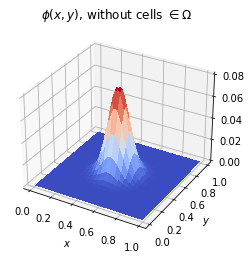

In [103]:
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, n_CPFM_1D_forward[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

#### n_alpha_Past_FE

In [ ]:
def B_construct_1D_RD(Nx, Ny, ghosts_included = True):
    """
    Input: Na (int), number of grid points
           ghosts_included (bool), default is True (B is (Na-2) x (Na-2) and rho is Na-2)
                                           if False (B is (Na) x (Na) and rho is Na)
    Output: B (float array), 1D Poisson discretization matrix
    """
    # construct the tridiagonal Poisson discretization matrix B
    if (ghosts_included):
        
        #offsets = [-1, 0, 1] 
        #diags = []
        #diags.append(-np.ones(Na-3)) 
        #diags.append(2 * np.ones(Na-2))
        #diags.append(-np.ones(Na-3))
        #B = scipy.sparse.diags(diags, offsets, format='csr') # construct a CSR version of B
        #B = B.toarray() # this function will only be called once so CSR not too important
        #print('The shape of B is', np.shape(B))
        #print('\nB is \n', B)  
        
        B = np.zeros((Nx, Ny))
        
        for i in range(Nx):
            for j in range(Ny):
                
                B[i][j] = 
        
        
        
        
        
        
    else:    
        offsets = [-1, 0, 1] 
        diags = []
        
        diags.append(-np.ones(Na-3)) 
        diags.append(2 * np.ones(Na-2))
        diags.append(-np.ones(Na-3))
        B = scipy.sparse.diags(diags, offsets, format='csr') # construct a CSR version of B
        B = B.toarray() # this function will only be called once so CSR not too important
        B = np.pad(B, [1, 1], mode='constant')
        B[0][0] = 1
        B[np.shape(B)[0]-1][np.shape(B)[0]-1] = 1
        #print('The shape of B is', np.shape(B))
        #print('\nB is \n', B)

    return B


def poisson_matrix_2D_RD(Na, ghosts_included = True):
    
    B = B_construct_1D(Na, ghosts_included)
    
    if (ghosts_included):
        
        # construct the Poisson discretization matrix A
        A = np.kron(B, np.eye(np.shape(B)[0])) + np.kron(np.eye(np.shape(B)[0]), B)
        
    else:
        
        print('Error: Not Implemented yet :) OOPS')
    
    print('The shape of B is', np.shape(B))
    print('The shape of A is', np.shape(A))
    
    return A

In [ ]:
def poisson_matrix_2D_RD(Na, ghosts_included = True):
    
    B = B_construct_1D(Na, ghosts_included)
    
    if (ghosts_included):
        
        # construct the Poisson discretization matrix A
        A = np.kron(B, np.eye(np.shape(B)[0])) + np.kron(np.eye(np.shape(B)[0]), B)
        
    else:
        
        print('Error: Not Implemented yet :) OOPS')
    
    print('The shape of B is', np.shape(B))
    print('The shape of A is', np.shape(A))
    
    return A

In [194]:
Bsus = np.array([[2, -1, 0, 0, 0], [-1, 2, -1, 0, 0], [0, -1, 2, -1, 0], [0, 0, -1, 2, -1], [0, 0, 0, -1, 2]])

Bsus = np.array([[2, -1], [-1, 2]])

Isus = np.eye(2)

In [195]:
Asus =  np.kron(Bsus, Isus) + np.kron(Isus, Bsus) 

nx, ny = (3, 5)

In [196]:
print(-Asus)

[[-4.  1.  1.  0.]
 [ 1. -4.  0.  1.]
 [ 1.  0. -4.  1.]
 [ 0.  1.  1. -4.]]


In [184]:
rhosus = np.ones(nx * ny)

xv is (1, 3)
yv is (5, 1)


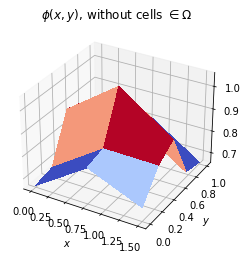

In [185]:
phisus = scipy.sparse.linalg.cg(Asus, rhosus)[0]

phisus = phisus.reshape((ny, nx))


x = np.linspace(0, 1.5, nx)
y = np.linspace(0, 1, ny)

xv, yv = np.meshgrid(x, y, sparse=True)

print('xv is', np.shape(xv))
print('yv is', np.shape(yv))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xv, yv, phisus, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

In [186]:
np.shape(phisus)

(5, 3)

In [114]:
np.shape(x_ax)

(2,)

# Rectangular KING

In [814]:
def poisson_matrix_2D_RD(Nx, Ny):
    
    A_matrix = np.zeros((Nx*Ny, Nx*Ny))
    
    for i in range(Nx*Ny):
        
        A_matrix[i][i] = -4
        
        if (i > 0):
            
            A_matrix[i-1][i] = 1
            
            if (((i + 1) % Nx == 1) and (i < Nx * Ny - 1)):
            
                A_matrix[i-1][i] = 0
                
                
        if (i < Nx * Ny) and (i > 0):
            
            A_matrix[i][i-1] = 1
            
        if (((i + 1) % Nx == 1) and (i > 2)):
            
            A_matrix[i][i-1] = 0
            
    
    A_matrix += np.diag(np.ones(Nx * Ny - Nx), -Nx) + np.diag(np.ones(Nx * Ny - Nx), Nx)
        
                
                
    return -A_matrix
    
    

In [838]:
Abc = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])

print(np.shape(Abc))
print(Abc)
print(Abc.flatten())

(4, 2)
[[1 2]
 [3 4]
 [5 6]
 [7 8]]
[1 2 3 4 5 6 7 8]


In [815]:
poisson_matrix_2D_RD(4, 2)

array([[ 4., -1., -0., -0., -1., -0., -0., -0.],
       [-1.,  4., -1., -0., -0., -1., -0., -0.],
       [-0., -1.,  4., -1., -0., -0., -1., -0.],
       [-0., -0., -1.,  4., -0., -0., -0., -1.],
       [-1., -0., -0., -0.,  4., -1., -0., -0.],
       [-0., -1., -0., -0., -1.,  4., -1., -0.],
       [-0., -0., -1., -0., -0., -1.,  4., -1.],
       [-0., -0., -0., -1., -0., -0., -1.,  4.]])

In [831]:
Asus = poisson_matrix_2D_RD(67, 15)

In [832]:
print(Asus)

[[ 4. -1. -0. ... -0. -0. -0.]
 [-1.  4. -1. ... -0. -0. -0.]
 [-0. -1.  4. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ...  4. -1. -0.]
 [-0. -0. -0. ... -1.  4. -1.]
 [-0. -0. -0. ... -0. -1.  4.]]


In [833]:
nx, ny = (67, 15)

In [834]:
rhosus = np.ones(nx * ny)

xv is (1, 69)
yv is (17, 1)


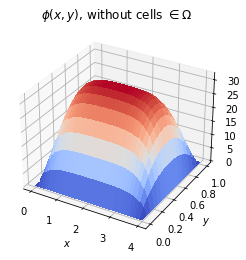

In [835]:
phisus = scipy.sparse.linalg.cg(Asus, rhosus)[0]

phisus = phisus.reshape((ny, nx))

phisus = np.pad(phisus, 1)


x = np.linspace(0, 4, nx+2)
y = np.linspace(0, 1, ny+2)

xv, yv = np.meshgrid(x, y, sparse=True)

print('xv is', np.shape(xv))
print('yv is', np.shape(yv))

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xv, yv, phisus, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

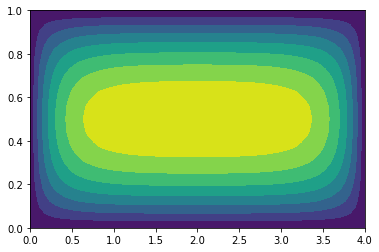

In [836]:
xv, yv = np.meshgrid(x, y)

plt.contourf(xv, yv, phisus)

xv is (35, 17)
yv is (35, 17)


TypeError: cannot unpack non-iterable QuadContourSet object

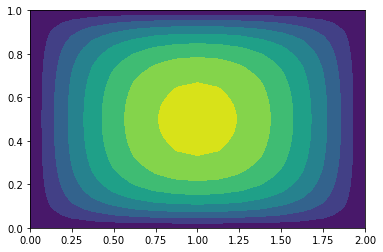

In [404]:
phisus = scipy.sparse.linalg.cg(Asus, rhosus)[0]

phisus = phisus.reshape((ny, nx))

phisus = np.pad(phisus, 1)


x = np.linspace(0, 2, nx+2)
y = np.linspace(0, 1, ny+2)

xv, yv = np.meshgrid(x, y, sparse=True)
xv, yv = np.meshgrid(x, y)

print('xv is', np.shape(xv))
print('yv is', np.shape(yv))

fig, ax = plt.contourf(xv, yv, phisus)
#surf = ax.plot_contour(xv, yv, phisus, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)
ax.set_title(r'$\phi(x,y)$, without cells $\in \Omega$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()